## Dog or Cat Image Detection with Transfer Learning

![](https://www.mypet.com/img/diabetes/2-5-1-DogCatLookingAtCamera-750x250.jpg)

In this notebook, I will experiment with a technique called transfer learning on the dog and cat dataset to see how significant its impact has on the model.

This technique is recommended by researchers and experts in deep learning when you are trying to train a model to solve similar tasks but only have a small dataset.

In this case, I have a pretty small dataset consisting of only 8000 training images and 2000 testing images. So to deal with this "small dataset" issue, I am going to:

- Use data augmentation to make the training set larger.
- Reuse the Inception V3 model's lower layers for my model.

### For comparison, I trained the below CNN model on Google Colab's GPU with 50 epochs and data augmentation.

Check out the notebook for this model [here](https://github.com/thanhdtnguyen/Deep-Learning-with-Keras-Tensorflow/blob/master/convnet_dog_cat_with_augmentation.ipynb)

After about 2 hours, I got 0.9053 accuracy on training set and 0.8820 on validation set.

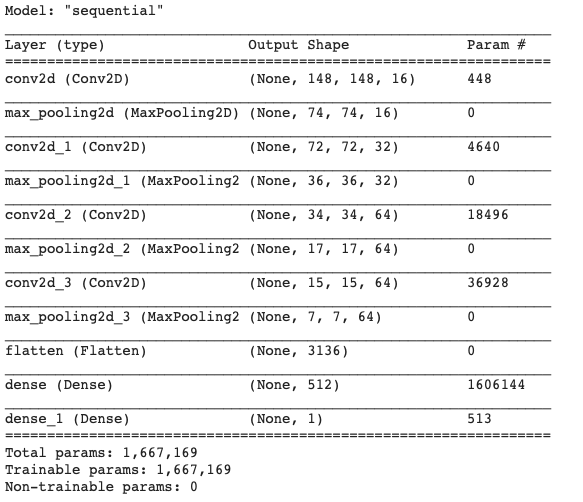

### Now, let's see the result after training my model with InceptionV3's layers.

In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
import random
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Model
from keras.preprocessing.image import ImageDataGenerator

# import Inception V3 for transfer learning

from keras.applications.inception_v3 import InceptionV3

### This is the schematic diagram of InceptionV3 model.

![](https://www.researchgate.net/profile/Masoud_Mahdianpari/publication/326421398/figure/fig6/AS:649353890889730@1531829440919/Schematic-diagram-of-InceptionV3-model-compressed-view.png)

In [3]:
training_dir = "../input/cat-and-dog/training_set/training_set/"
testing_dir = "/kaggle/input/cat-and-dog/test_set/test_set/"

training_cats_dir = "/kaggle/input/cat-and-dog/training_set/training_set/cats/"
training_dogs_dir = "../input/cat-and-dog/training_set/training_set/dogs/"

testing_cats_dir = "/kaggle/input/cat-and-dog/test_set/test_set/cats/"
testing_dogs_dir = "/kaggle/input/cat-and-dog/test_set/test_set/dogs/"

print(len(os.listdir(training_cats_dir)))
print(len(os.listdir(training_dogs_dir)))
print(len(os.listdir(testing_cats_dir)))
print(len(os.listdir(testing_dogs_dir)))

4001
4006
1012
1013


In [4]:
base_convnet = InceptionV3(input_shape = (150,150,3),
                           include_top = False,
                           weights = "imagenet")

base_convnet.trainable = False 

last_layer = base_convnet.get_layer("mixed7")

last_output = last_layer.output

87916544/87910968 [==============================] - 1s 0us/step


In [5]:
# build a model based on the Inception V3
# add 2 hidden dense layers with ELU activation and He initializer
# add 10% dropout rate

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation="elu", kernel_initializer="he_normal")(x)
x = layers.Dense(512, activation="elu", kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(1, activation="sigmoid")(x)

model = Model(base_convnet.input, x)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# model.summary()
# keras.utils.plot_model(model)

In [6]:
# callback function, stop training if there is no improvement after 5 epochs 

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [7]:
# image generator with data augmentation to increase the size of training set

train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode="nearest")

train_generator = train_datagen.flow_from_directory(training_dir,
                                                   target_size=(150,150),
                                                   batch_size=64,
                                                   class_mode="binary")

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

validation_generator = validation_datagen.flow_from_directory(testing_dir,
                                                 target_size=(150,150),
                                                 batch_size=32,
                                                 class_mode="binary")

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [8]:
# train the model

history = model.fit(train_generator,
                   epochs=20,
                   verbose=1,
                   validation_data=validation_generator,
                   callbacks=early_stopping_cb)

Epoch 1/20
126/126 [==============================] - 99s 790ms/step - loss: 0.5110 - accuracy: 0.8876 - val_loss: 0.0950 - val_accuracy: 0.9629
Epoch 2/20
126/126 [==============================] - 72s 572ms/step - loss: 0.1853 - accuracy: 0.9244 - val_loss: 0.1182 - val_accuracy: 0.9511
Epoch 3/20
126/126 [==============================] - 72s 572ms/step - loss: 0.1628 - accuracy: 0.9304 - val_loss: 0.0802 - val_accuracy: 0.9708
Epoch 4/20
126/126 [==============================] - 72s 574ms/step - loss: 0.1487 - accuracy: 0.9374 - val_loss: 0.0875 - val_accuracy: 0.9664
Epoch 5/20
126/126 [==============================] - 72s 574ms/step - loss: 0.1581 - accuracy: 0.9367 - val_loss: 0.0733 - val_accuracy: 0.9723
Epoch 6/20
126/126 [==============================] - 73s 576ms/step - loss: 0.1385 - accuracy: 0.9440 - val_loss: 0.0887 - val_accuracy: 0.9664
Epoch 7/20
126/126 [==============================] - 72s 572ms/step - loss: 0.1318 - accuracy: 0.9434 - val_loss: 0.0798 - val_ac

In [9]:
# save the model

model.save("dog_or_cat_with_inceptionv3.h5")

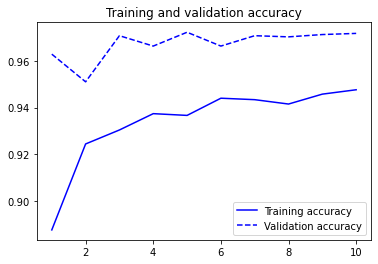

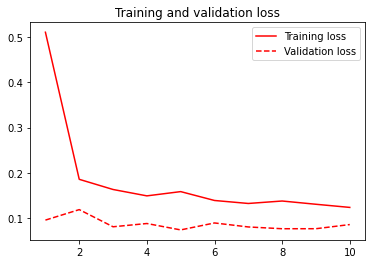

In [10]:
# plot accuracy and loss

import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

# accuracy

plt.plot(epochs, acc, "b", label="Training accuracy")
plt.plot(epochs, val_acc, "b--", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

# loss

plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### The Result 

**After training my new model with InceptionV3's layers with much fewer epochs, I was able to get considerably higher accuracy for both training and validation set.**

So at this point, I can conclude that this transfer learning approach is far more superior than training my own model from scratch with a very small dataset. This approach save me lots of time and also the cost of training with GPU.